In [1]:
!pip install xmltodict
import json
import os
import time
import torch
import spacy
import pickle
import joblib
import argparse
import xmltodict
import numpy as np
from collections import Counter
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
nlp = spacy.load("en")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Environment variables

##Constants

In [3]:
root = '/content/drive/MyDrive/DL/A4/ABSA complete Dataset/'
train_path = root + 'ABSA Train/'
test_path = root + 'ABSA Test/'

restaurant_path = root + 'temp/data/restaurant/'
restaurant_xml_train = train_path + 'Restaurants_Train.xml'
restaurant_xml_test = test_path + 'Restaurants_Test_Gold.xml'
laptop_path = root + 'temp/data/laptop/'
laptop_xml_train = train_path + 'Laptops_Train.xml'
laptop_xml_test = test_path + 'Laptops_Test_Gold.xml'
key_sentences = 'sentences'
key_sentence = 'sentence'

key_text = 'text'
key_aspectTerms = 'aspectTerms'
key_aspectTerm = 'aspectTerm'
key_from = '@from'
key_to = '@to'
key_term = '@term'
key_polarity = '@polarity'
ASPECT_TERM = 'aspect_term'
saved = True

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument('--embedding_size', default=300)
parser.add_argument('--batch_size', default=64)
parser.add_argument('--epochs', default=20)
parser.add_argument('--hidden_size', default=300)
parser.add_argument('--n_class', default=3)
parser.add_argument('--pre_processed', default=False)
parser.add_argument('--learning_rate', default=0.001)
parser.add_argument('--l2_reg', default=1e-5)
parser.add_argument('--clip', default=3.0)
parser.add_argument('--dropout', default=0.5)
parser.add_argument('--max_aspect_len', default=0)
parser.add_argument('--max_context_len', default=0)
#parser.add_argument('--dataset', default=restaurant_path)
parser.add_argument('--dataset', default=laptop_path)

parser.add_argument('--embedding_file_name', default='/content/drive/MyDrive/DL/A3/data/glove.840B.300d.txt')
parser.add_argument('--embedding', default=0)
parser.add_argument('--vocab_size', default=0)
parser.add_argument('--attention', default=True)



config, unknown = parser.parse_known_args()

config.dataset = restaurant_path
config.modelName = f'model-{"IAN" if config.attention else "NO-ATTN"}.pkl'

#Util functions


## XML to Json

In [5]:
def get_json(path):
  restaurant_data = None
  with open(path) as xml_file:
    restaurant_data = xmltodict.parse(xml_file.read())
    xml_file.close()
    return [key for key in restaurant_data[key_sentences][key_sentence]]

## Filter to remove sentences without any text or aspect term

In [6]:
def filter_data(sentenceArr):
  count = 0
  filteredSentence = []
  for sentence in sentenceArr:
    d = dict() 
    for x in sentence:
      if x in [key_text, key_aspectTerms]:
        d[x] = sentence[x]
    if len(d.keys()) >= 2:
      filteredSentence.append(d)
    else:
      count = count + 1
      sentence
  print(f'{count} sentences do not have aspectTerm(s)')
  return filteredSentence

##json of sentences + aspects into preprocessed string

In [7]:
def parse_data(filteredSentence):
  out = ''
  for ss in filteredSentence:
    curSentence = ''
    for x in ss[key_aspectTerms]:
      if isinstance(ss[key_aspectTerms][x], list):
        for aspect in ss[key_aspectTerms][x]:
          token = ss[key_text][int(aspect[key_from]):int(aspect[key_to])]
          curSentence += ss[key_text].replace(token,ASPECT_TERM)+'\n'
          curSentence += aspect[key_term]+'\n'
          curSentence += aspect[key_polarity]+'\n'
      else:
        token = ss[key_text][int(ss[key_aspectTerms][x][key_from]):int(ss[key_aspectTerms][x][key_to])]
        curSentence += ss[key_text].replace(token,ASPECT_TERM)+'\n'
        curSentence += ss[key_aspectTerms][x][key_term]+'\n'
        curSentence += ss[key_aspectTerms][x][key_polarity]+'\n'
    out += curSentence
  return out

## save preprocessed data in string into a file

In [8]:
def save_preprocessed(data_string, path):
  text_file = open(path, "w")
  text_file.write(data_string)
  text_file.close()


## Saving and Loading models using joblib 

In [9]:
def save(filename, obj):
  with open(filename, 'wb') as handle:
      joblib.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
  with open(filename, 'rb') as handle:
      return joblib.load(filename)

#Restaurant Dataset


## Train

In [10]:
sentenceArr_train = get_json(restaurant_xml_train)
filteredSentence_train = filter_data(sentenceArr_train)
data_text_train = parse_data(filteredSentence_train)
save_preprocessed(data_text_train, restaurant_path+"train.txt")

1021 sentences do not have aspectTerm(s)


## Test

In [11]:
sentenceArr_test = get_json(restaurant_xml_test)
filteredSentence_test = filter_data(sentenceArr_test)
data_text_test = parse_data(filteredSentence_test)
save_preprocessed(data_text_test, restaurant_path+"test.txt")

194 sentences do not have aspectTerm(s)


# Laptop Dataset

## Train

In [12]:
sentenceArr_train = get_json(laptop_xml_train)
filteredSentence_train = filter_data(sentenceArr_train)
data_text_train = parse_data(filteredSentence_train)
save_preprocessed(data_text_train, laptop_path+"train.txt")

1556 sentences do not have aspectTerm(s)


##Test

In [13]:
sentenceArr_test = get_json(laptop_xml_test)
filteredSentence_test = filter_data(sentenceArr_test)
data_text_test = parse_data(filteredSentence_test)
save_preprocessed(data_text_test, laptop_path+"test.txt")

378 sentences do not have aspectTerm(s)


#Model Training

## Data preprocessing and vocab/embedding

In [14]:
def preprocess_createdict(fname, words, word2id):
  max_aspect_len, max_context_len = 0, 0
  word2id['<pad>'] = 0
  lines = open(fname, 'r').readlines()
  for i in range(0, len(lines), 3):
      sptoks = nlp(lines[i].strip())
      words.extend([sp.text.lower() for sp in sptoks])
      if len(sptoks) - 1 > max_context_len:
          max_context_len = len(sptoks) - 1
      sptoks = nlp(lines[i + 1].strip())
      if len(sptoks) > max_aspect_len:
          max_aspect_len = len(sptoks)
      words.extend([sp.text.lower() for sp in sptoks])
  word_count = Counter(words).most_common()
  for word, _ in word_count:
      if word not in word2id and ' ' not in word and '\n' not in word and 'aspect_term' not in word:
          word2id[word] = len(word2id)
  return word2id, words, max_aspect_len, max_context_len

def get_data_info(dataset, pre_processed):
    train_fname = dataset + 'train.txt'
    test_fname = dataset + 'test.txt'
    save_fname = dataset + 'data_info.txt'

    if pre_processed:
        with open(save_fname, 'r') as f:
            for line in f:
                content = line.strip().split()
                if len(content) == 3:
                    max_aspect_len = int(content[1])
                    max_context_len = int(content[2])
                else:
                    word2id[content[0]] = int(content[1])
    else:

        word2id, words, max_aspect_len, max_context_len = preprocess_createdict(train_fname, [], {})
        word2id, words, max_aspect_len2, max_context_len2 = preprocess_createdict(test_fname, words, word2id)

        max_aspect_len = max(max_aspect_len, max_aspect_len2)
        max_context_len = max(max_context_len, max_context_len2)
        with open(save_fname, 'w') as f:
            f.write('length %s %s\n' % (max_aspect_len, max_context_len))
            for key, value in word2id.items():
                f.write('%s %s\n' % (key, value))

    print('There are %s words in the dataset, the max length of aspect is %s, and the max length of context is %s' % (
    len(word2id), max_aspect_len, max_context_len))
    return word2id, max_aspect_len, max_context_len


def read_data(word2id, max_aspect_len, max_context_len, dataset, pre_processed):
    fname = dataset + '.txt'
    save_fname = dataset + '.npz'

    if pre_processed:
        return save_fname
    else:
        aspects, contexts, labels, aspect_lens, context_lens = list(), list(), list(), list(), list()
        lines = open(fname, 'r').readlines()
        for i in range(0, len(lines), 3):
            polarity = lines[i + 2].split()[0]
            if polarity == 'conflict':
                continue

            context_sptoks = nlp(lines[i].strip())
            context = []
            for sptok in context_sptoks:
                if sptok.text.lower() in word2id:
                    context.append(word2id[sptok.text.lower()])

            aspect_sptoks = nlp(lines[i + 1].strip())
            aspect = []
            for aspect_sptok in aspect_sptoks:
                if aspect_sptok.text.lower() in word2id:
                    aspect.append(word2id[aspect_sptok.text.lower()])

            aspects.append(aspect + [0] * (max_aspect_len - len(aspect)))
            contexts.append(context + [0] * (max_context_len - len(context)))
            if polarity == 'negative':
                labels.append(0)
            elif polarity == 'neutral':
                labels.append(1)
            elif polarity == 'positive':
                labels.append(2)
            aspect_lens.append(len(aspect_sptoks))
            context_lens.append(len(context_sptoks) - 1)
        print("Read %s examples from %s" % (len(aspects), fname))
        aspects = np.asarray(aspects)
        contexts = np.asarray(contexts)
        labels = np.asarray(labels)
        aspect_lens = np.asarray(aspect_lens)
        context_lens = np.asarray(context_lens)
        np.savez(save_fname, aspects=aspects, contexts=contexts, labels=labels, aspect_lens=aspect_lens, context_lens=context_lens)
        return save_fname

def load_word_embeddings(fname, embedding_dim, word2id):

    word2vec = np.random.uniform(-0.01, 0.01, [len(word2id), embedding_dim])
    oov = len(word2id)
    with open(fname, 'r', encoding='utf-8') as f:
        for line in f:
            content = line.split(' ')
            if content[0] in word2id:
                word2vec[word2id[content[0]]] = np.array(list(map(float, content[1:])))
                oov = oov - 1
    word2vec[word2id['<pad>'], :] = 0
    print('There are %s words in vocabulary and %s words out of vocabulary' % (len(word2id) - oov, oov))
    return word2vec

## Model runner

In [15]:
class Attention(nn.Module):

    def __init__(self, query_size, key_size):
        super(Attention, self).__init__()
        self.weights = nn.Parameter(torch.rand(key_size, query_size) * 0.2 - 0.1)
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, query, key, mask):
        # query: (batch_size, query_size)
        # key: (batch_size, time_step, key_size)
        # value: (batch_size, time_step, value_size)
        # mask: (batch_size, time_step)
        batch_size = key.size(0)
        time_step = key.size(1)
        '[batch_size, key_size, query_size]'
        weights = self.weights.repeat(batch_size, 1, 1)
        '[batch_size, query_size, 1]'
        query = query.unsqueeze(-1)
        '[batch_size, key_size, 1]'
        mids = weights.matmul(query)
        '[batch_size, time_step, key_size, 1]'
        mids = mids.repeat(time_step, 1, 1, 1).transpose(0, 1)
        '[batch_size, time_step, 1, key_size]'
        key = key.unsqueeze(-2)
        '[batch_size, time_step, 1, 1]'
        scores = torch.tanh(key.matmul(mids).squeeze() + self.bias)
        '[batch_size, time_step]'
        scores = scores.squeeze()
        scores = scores - scores.max(dim=1, keepdim=True)[0]
        scores = torch.exp(scores) * mask
        attn_weights = scores / scores.sum(dim=1, keepdim=True)
        return attn_weights

class IAN(nn.Module):
    def __init__(self, config):
        super(IAN, self).__init__()
        self.vocab_size = config.vocab_size
        self.embedding_size = config.embedding_size
        self.hidden_size = config.hidden_size
        self.n_class = config.n_class
        self.l2_reg = config.l2_reg
        self.max_aspect_len = config.max_aspect_len
        self.max_context_len = config.max_context_len

        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_size)
        self.aspect_lstm = nn.LSTM(input_size=self.embedding_size, hidden_size=self.hidden_size, batch_first=True)
        self.context_lstm = nn.LSTM(input_size=self.embedding_size, hidden_size=self.hidden_size, batch_first=True)

        self.aspect_attn = Attention(self.hidden_size, self.hidden_size)
        self.context_attn = Attention(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(config.dropout)
        self.fc = nn.Linear(self.hidden_size * 2, self.n_class)
        self.embedding.weight.data.copy_(torch.from_numpy(config.embedding))

    def forward(self, aspect, context, aspect_mask, context_mask):
        aspect = self.embedding(aspect)
        aspect = self.dropout(aspect)
        aspect_output, _ = self.aspect_lstm(aspect)
        aspect_output = aspect_output * aspect_mask.unsqueeze(-1)
        aspect_avg = aspect_output.sum(dim=1, keepdim=False) / aspect_mask.sum(dim=1, keepdim=True)

        context = self.embedding(context)
        context = self.dropout(context)
        context_output, _ = self.context_lstm(context)
        context_output = context_output * context_mask.unsqueeze(-1)
        context_avg = context_output.sum(dim=1, keepdim=False) / context_mask.sum(dim=1, keepdim=True)

        aspect_attn = self.aspect_attn(context_avg, aspect_output, aspect_mask).unsqueeze(1)
        aspect_features = aspect_attn.matmul(aspect_output).squeeze()
        context_attn = self.context_attn(aspect_avg, context_output, context_mask).unsqueeze(1)
        context_features = context_attn.matmul(context_output).squeeze()
        features = torch.cat([aspect_features, context_features], dim=1)

        features = self.dropout(features)
        output = self.fc(features)
        output = torch.tanh(output)
        return output, aspect_attn, context_attn

class NN(nn.Module):
    def __init__(self, config):
        super(NN, self).__init__()
        self.vocab_size = config.vocab_size
        self.embedding_size = config.embedding_size
        self.hidden_size = config.hidden_size
        self.n_class = config.n_class
        self.l2_reg = config.l2_reg
        self.max_aspect_len = config.max_aspect_len
        self.max_context_len = config.max_context_len

        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_size)
        self.aspect_lstm = nn.LSTM(input_size=self.embedding_size, hidden_size=self.hidden_size, batch_first=True)
        self.context_lstm = nn.LSTM(input_size=self.embedding_size, hidden_size=self.hidden_size, batch_first=True)

        self.dropout = nn.Dropout(config.dropout)
        self.fc = nn.Linear(self.hidden_size * 2, self.n_class)
        self.embedding.weight.data.copy_(torch.from_numpy(config.embedding))

    def forward(self, aspect, context, aspect_mask, context_mask):
        aspect = self.embedding(aspect)
        aspect = self.dropout(aspect)
        aspect_output, _ = self.aspect_lstm(aspect)
        aspect_output = aspect_output * aspect_mask.unsqueeze(-1)
        aspect_avg = aspect_output.sum(dim=1, keepdim=False) / aspect_mask.sum(dim=1, keepdim=True)

        context = self.embedding(context)
        context = self.dropout(context)
        context_output, _ = self.context_lstm(context)
        context_output = context_output * context_mask.unsqueeze(-1)
        context_avg = context_output.sum(dim=1, keepdim=False) / context_mask.sum(dim=1, keepdim=True)

        features = torch.cat([aspect_avg, context_avg], dim=1)

        features = self.dropout(features)
        output = self.fc(features)
        output = torch.tanh(output)
        return output

class IanDataset(Dataset):

    def __init__(self, path):
        data = np.load(path)
        self.aspects = torch.from_numpy(data['aspects']).long()
        self.contexts = torch.from_numpy(data['contexts']).long()
        self.labels = torch.from_numpy(data['labels']).long()
        self.aspect_lens = torch.from_numpy(data['aspect_lens']).long()
        self.context_lens = torch.from_numpy(data['context_lens']).long()
        self.len = self.labels.shape[0]
        aspect_max_len = self.aspects.size(1)
        context_max_len = self.contexts.size(1)
        self.aspect_mask = torch.zeros(aspect_max_len, aspect_max_len)
        self.context_mask = torch.zeros(context_max_len, context_max_len)
        for i in range(aspect_max_len):
            self.aspect_mask[i, 0:i + 1] = 1
        for i in range(context_max_len):
            self.context_mask[i, 0:i + 1] = 1

    def __getitem__(self, index):
        return self.aspects[index], self.contexts[index], self.labels[index], \
               self.aspect_mask[self.aspect_lens[index] - 1], self.context_mask[self.context_lens[index] - 1]

    def __len__(self):
        return self.len

##IAN


In [16]:
def main(saved=False):
    saved = True
    if saved == True:
      (word2id, config.max_aspect_len, config.max_context_len) = load(config.dataset+'w2id-asp-len-contex-len.pkl')
      config.vocab_size = len(word2id)
      (train_data, test_data) = load(config.dataset+'train_test'+'.pkl')
      config.embedding = load(config.dataset+'embedding'+'.pkl')
      (train_dataset, test_dataset) = load(config.dataset+'train_test_dataset'+'.pkl')
      (train_loader, test_loader) = load(config.dataset+'train_test_loader'+'.pkl')   
    else:
      word2id, config.max_aspect_len, config.max_context_len = get_data_info(config.dataset, config.pre_processed)
      #save, load
      save(config.dataset+'w2id-asp-len-contex-len.pkl', (word2id, config.max_aspect_len, config.max_context_len))
      (word2id, config.max_aspect_len, config.max_context_len) = load(config.dataset+'w2id-asp-len-contex-len.pkl')

      config.vocab_size = len(word2id)
      print(f'config.vocab_size: {config.vocab_size}, config.max_aspect_len: {config.max_aspect_len}, config.max_context_len: {config.max_context_len}')
      train_data = read_data(word2id, config.max_aspect_len, config.max_context_len, config.dataset + 'train',
                           config.pre_processed)
      test_data = read_data(word2id, config.max_aspect_len, config.max_context_len, config.dataset + 'test',
                          config.pre_processed)
      #save, load
      save(config.dataset+'train_test'+'.pkl', (train_data, test_data))
      (train_data, test_data) = load(config.dataset+'train_test'+'.pkl')
      config.embedding = load_word_embeddings(config.embedding_file_name, config.embedding_size, word2id)
      #save, load
      save(config.dataset+'embedding'+'.pkl', config.embedding)
      config.embedding = load(config.dataset+'embedding'+'.pkl')

      train_dataset = IanDataset(train_data)
      test_dataset = IanDataset(test_data)
      #save, load
      save(config.dataset+'train_test_dataset'+'.pkl', (train_dataset, test_dataset))
      (train_dataset, test_dataset) = load(config.dataset+'train_test_dataset'+'.pkl')


      train_loader = DataLoader(dataset=train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
      test_loader = DataLoader(dataset=test_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
      #save, load
      save(config.dataset+'train_test_loader.pkl', (train_loader, test_loader))
      (train_loader, test_loader) = load(config.dataset+'train_test_loader'+'.pkl')
    return train_loader, test_loader, word2id

train_loader, test_loader, word2id = main(saved)

In [17]:
if config.attention == True:
  saved = True
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  if saved == True:
    model = load(config.dataset+config.modelName)
    test_total_cases = 0
    test_correct_cases = 0
    for data in test_loader:
        aspects, contexts, labels, aspect_masks, context_masks = data
        aspects, contexts, labels = aspects.to(device), contexts.to(device), labels.to(device)
        aspect_masks, context_masks = aspect_masks.to(device), context_masks.to(device)
        outputs, aspect_attn, context_attn = model(aspects, contexts, aspect_masks, context_masks)
        _, predicts = outputs.max(dim=1)
        test_total_cases += labels.shape[0]
        test_correct_cases += (predicts == labels).sum().item()
    test_accuracy = test_correct_cases / test_total_cases
    print('test accuracy: %.4f' % (test_accuracy))
  else:
    model = IAN(config).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.l2_reg)
    max_acc = 0
    for epoch in range(config.epochs):
        train_total_cases = 0
        train_correct_cases = 0
        for data in train_loader:
          aspects, contexts, labels, aspect_masks, context_masks = data
          aspects, contexts, labels = aspects.to(device), contexts.to(device), labels.to(device)
          aspect_masks, context_masks = aspect_masks.to(device), context_masks.to(device)
          optimizer.zero_grad()
          outputs, aspect_attn, context_attn = model(aspects, contexts, aspect_masks, context_masks)
          _, predicts = outputs.max(dim=1)
          train_total_cases += labels.shape[0]
          train_correct_cases += (predicts == labels).sum().item()
          loss = criterion(outputs, labels)
          loss.backward()
          nn.utils.clip_grad_norm_(model.parameters(), config.clip)
          optimizer.step()
        train_accuracy = train_correct_cases / train_total_cases
        test_total_cases = 0
        test_correct_cases = 0
        for data in test_loader:
          aspects, contexts, labels, aspect_masks, context_masks = data
          aspects, contexts, labels = aspects.to(device), contexts.to(device), labels.to(device)
          aspect_masks, context_masks = aspect_masks.to(device), context_masks.to(device)
          outputs, aspect_attn, context_attn  = model(aspects, contexts, aspect_masks, context_masks)
          _, predicts = outputs.max(dim=1)
          test_total_cases += labels.shape[0]
          test_correct_cases += (predicts == labels).sum().item()
        test_accuracy = test_correct_cases / test_total_cases
        print('[epoch %02d] train accuracy: %.2f test accuracy: %.2f' % (epoch, train_accuracy, test_accuracy))
        max_acc = max(max_acc, test_accuracy)
        #save, load
        save(config.dataset+config.modelName, model)
        model = load(config.dataset+config.modelName)
        print('max test accuracy:', max_acc)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


test accuracy: 0.7277


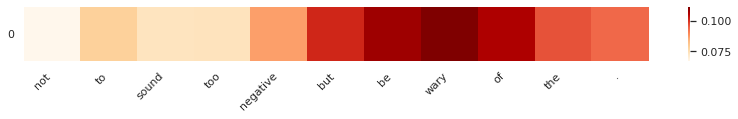

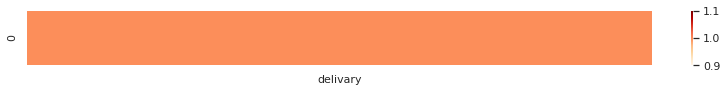

############


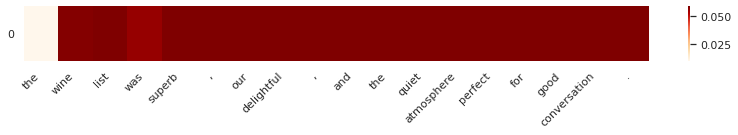

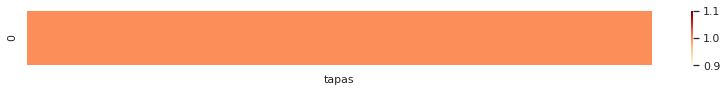

############


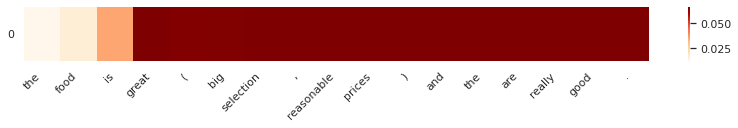

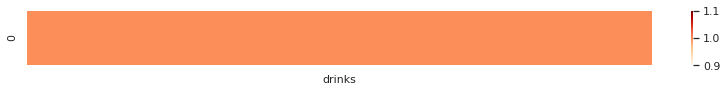

############


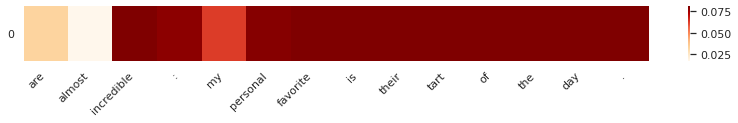

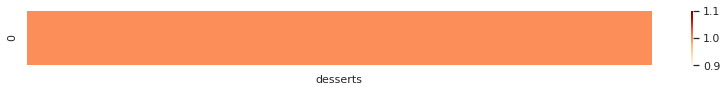

############


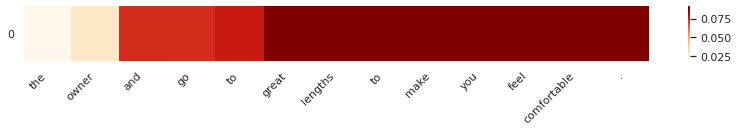

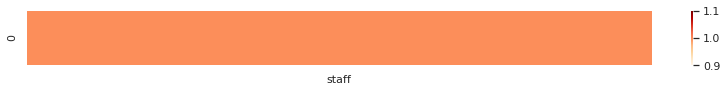

############


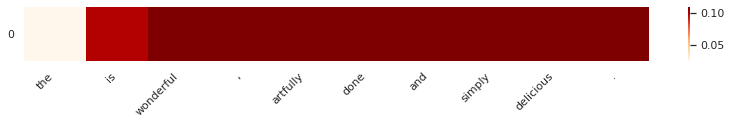

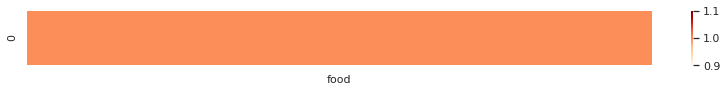

############


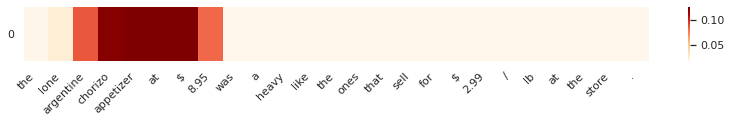

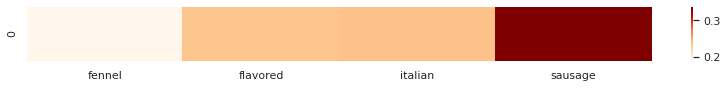

############


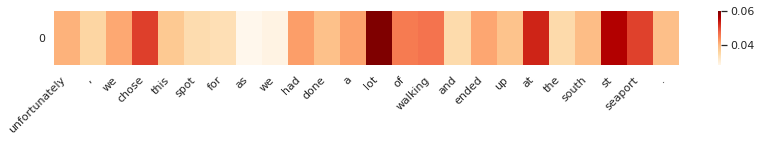

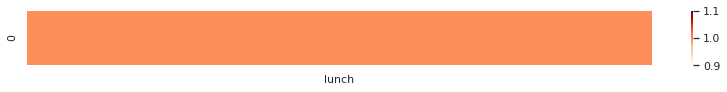

############


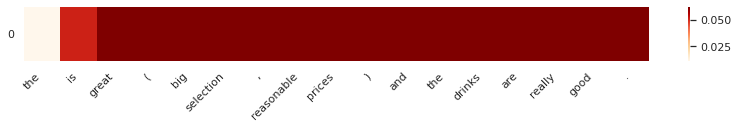

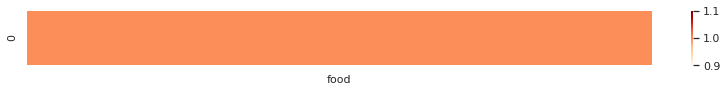

############


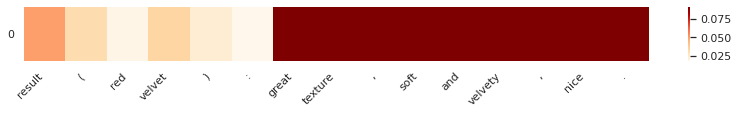

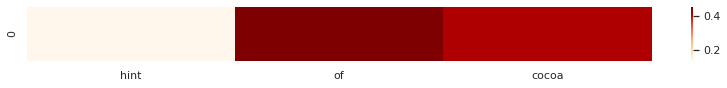

############


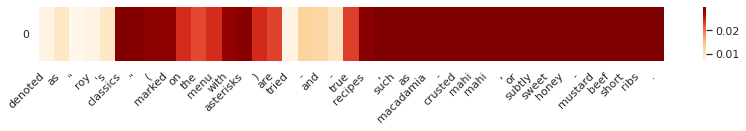

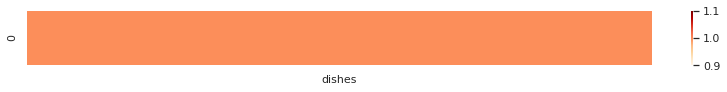

############


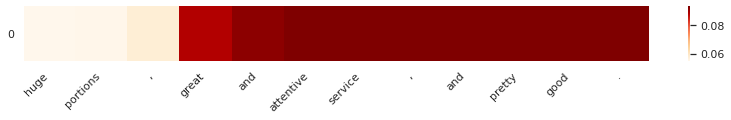

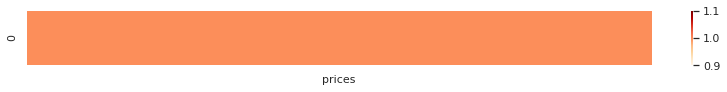

############


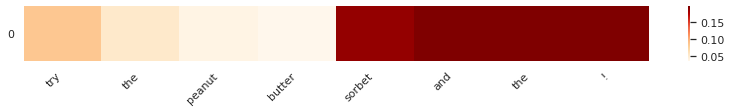

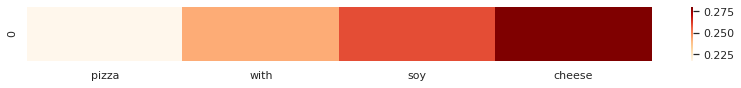

############


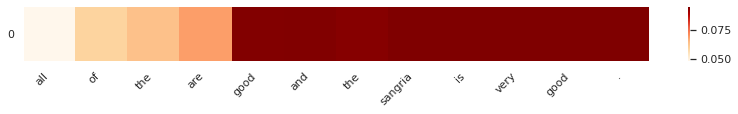

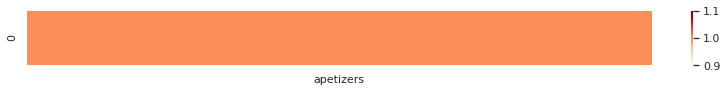

############


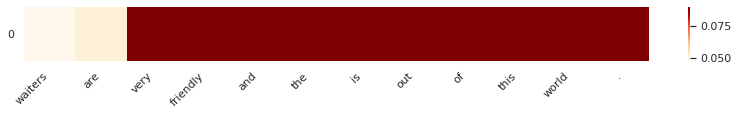

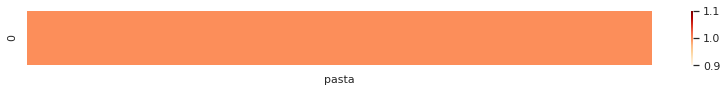

############


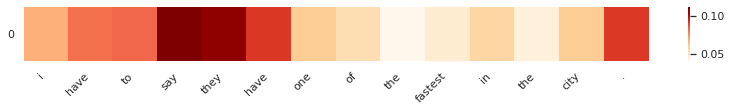

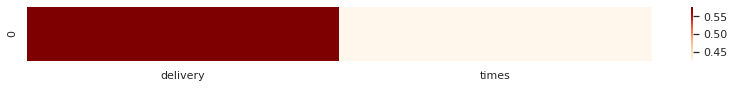

############


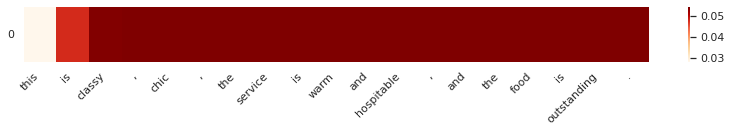

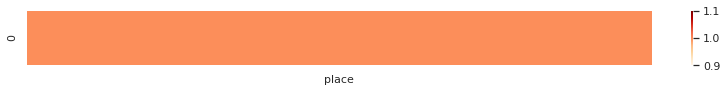

############


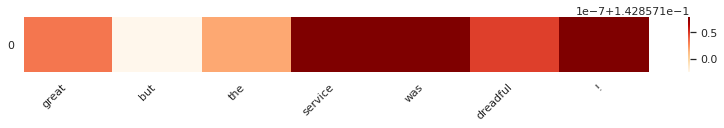

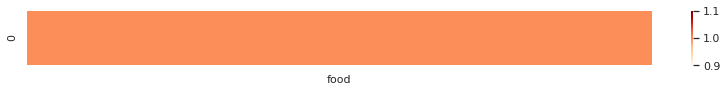

############


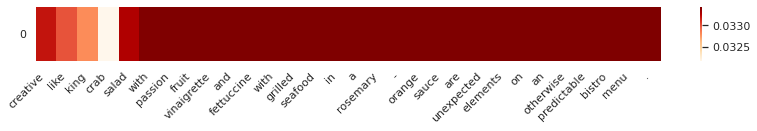

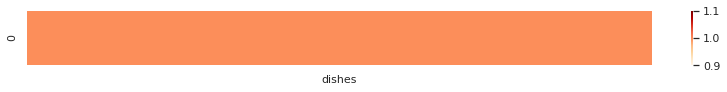

############


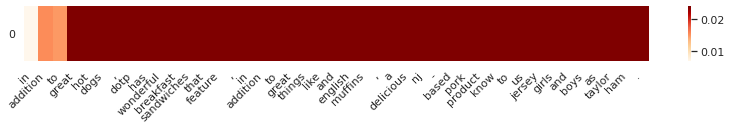

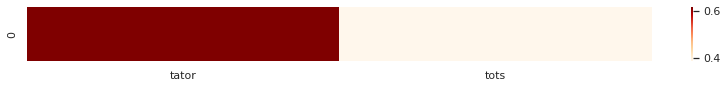

############


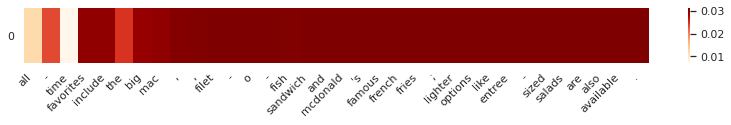

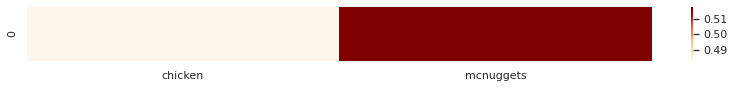

############


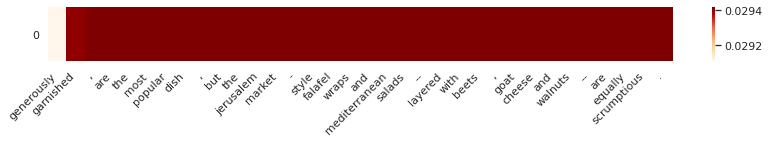

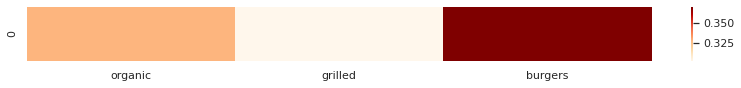

############


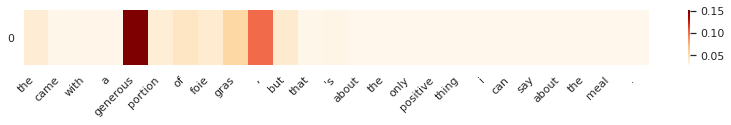

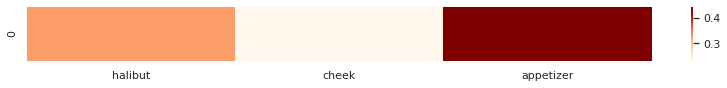

############


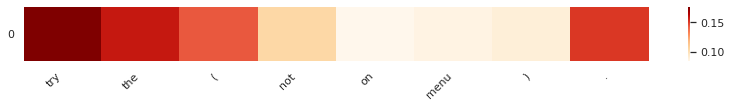

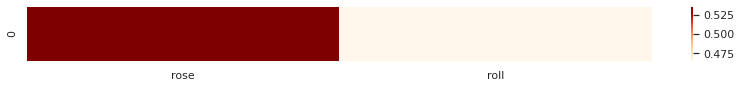

############


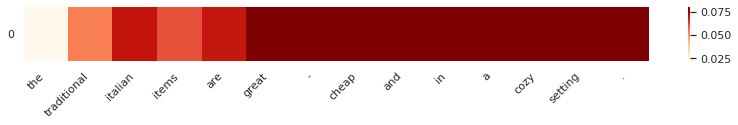

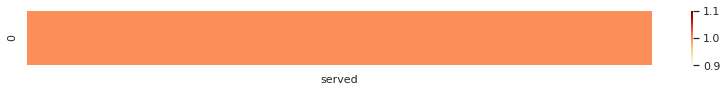

############


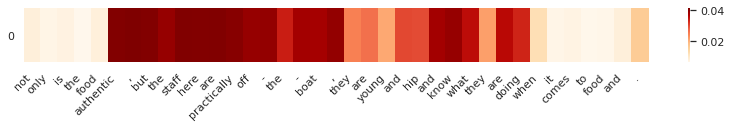

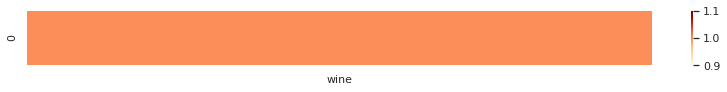

############


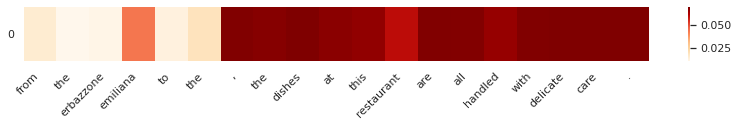

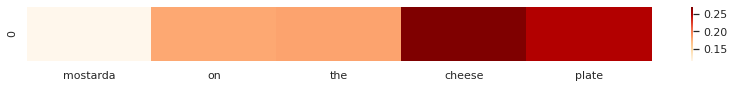

############


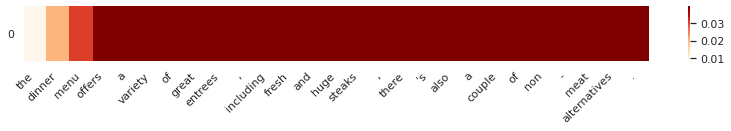

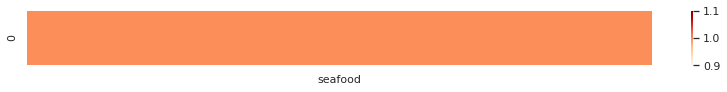

############


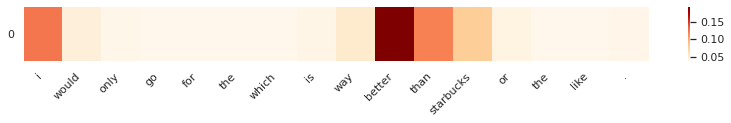

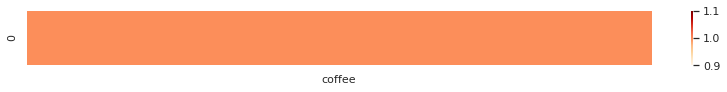

############


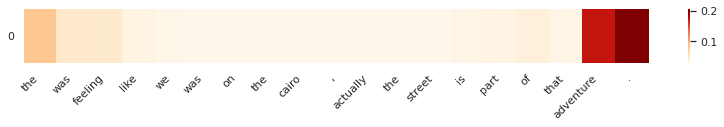

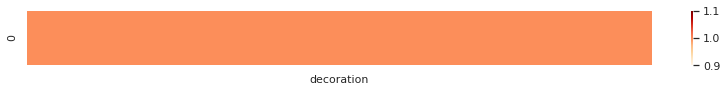

############


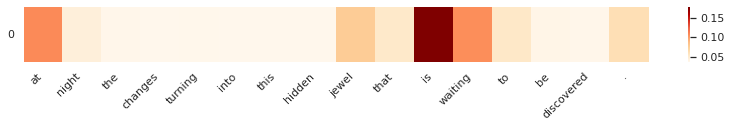

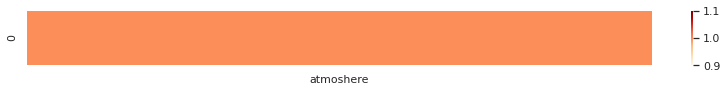

############


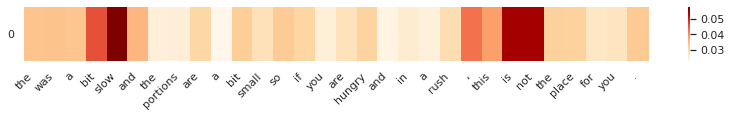

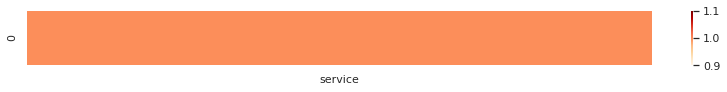

############


In [18]:
def trimmed_words(t):
      count = 0
      for x in t:
        if x == 0:
          break
        count = count + 1
      return t[:count]
      
if config.attention == True:
  key_list = list(word2id.keys())
  val_list = list(word2id.values())

  for context, aspect, cont_weight, aspect_weight in zip(contexts, aspects, context_attn, aspect_attn):
    context_out = trimmed_words(context)
    context_words = [key_list[val_list[x]] for x in context_out]
    aspect_out = trimmed_words(aspect)
    aspect_words = [key_list[val_list[x]] for x in aspect_out]

    con_weight_out = cont_weight[0][:len(context_words)]
    aspect_weight_out = aspect_weight[0][:len(aspect_words)]

    a = [x.item() for x in con_weight_out]
    b = [x.item() for x in aspect_weight_out]
    d = pd.DataFrame(data = [a], columns=context_words)
    f, ax = plt.subplots(figsize=(14,1))
    sns.heatmap(d, vmin=min(a), vmax=max(a), ax=ax, cmap="OrRd")
    label_y = ax.get_yticklabels()
    plt.setp(label_y, rotation=360, horizontalalignment='right')
    label_x = ax.get_xticklabels()
    plt.setp(label_x, rotation=45, horizontalalignment='right')
    d = pd.DataFrame(data = [b], columns=aspect_words)
    f, ax = plt.subplots(figsize=(14,1))
    sns.heatmap(d, vmin=min(b), vmax=max(b), ax=ax, cmap="OrRd")
    plt.show()


    print('############')

## NN (Baseline)

In [20]:
config.attention = False
config.modelName = f'model-{"IAN" if config.attention else "NO-ATTN"}.pkl'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if config.attention == False:
  saved = True
  if saved == True:
    model = load(config.dataset+config.modelName)
    test_total_cases = 0
    test_correct_cases = 0
    for data in test_loader:
      aspects, contexts, labels, aspect_masks, context_masks = data
      aspects, contexts, labels = aspects.to(device), contexts.to(device), labels.to(device)
      aspect_masks, context_masks = aspect_masks.to(device), context_masks.to(device)
      outputs = model(aspects, contexts, aspect_masks, context_masks)
      _, predicts = outputs.max(dim=1)
      test_total_cases += labels.shape[0]
      test_correct_cases += (predicts == labels).sum().item()
    test_accuracy = test_correct_cases / test_total_cases
    print('test accuracy: %.4f' % (test_accuracy))
  else:
    model = NN(config).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.l2_reg)
    max_acc = 0
    for epoch in range(config.epochs):
        train_total_cases = 0
        train_correct_cases = 0
        for data in train_loader:
            aspects, contexts, labels, aspect_masks, context_masks = data
            aspects, contexts, labels = aspects.to(device), contexts.to(device), labels.to(device)
            aspect_masks, context_masks = aspect_masks.to(device), context_masks.to(device)
            optimizer.zero_grad()
            outputs = model(aspects, contexts, aspect_masks, context_masks)
            _, predicts = outputs.max(dim=1)
            train_total_cases += labels.shape[0]
            train_correct_cases += (predicts == labels).sum().item()
            loss = criterion(outputs, labels)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), config.clip)
            optimizer.step()
        train_accuracy = train_correct_cases / train_total_cases
        test_total_cases = 0
        test_correct_cases = 0
        for data in test_loader:
            aspects, contexts, labels, aspect_masks, context_masks = data
            aspects, contexts, labels = aspects.to(device), contexts.to(device), labels.to(device)
            aspect_masks, context_masks = aspect_masks.to(device), context_masks.to(device)
            outputs = model(aspects, contexts, aspect_masks, context_masks)
            _, predicts = outputs.max(dim=1)
            test_total_cases += labels.shape[0]
            test_correct_cases += (predicts == labels).sum().item()
        test_accuracy = test_correct_cases / test_total_cases
        print('[epoch %02d] train accuracy: %.2f test accuracy: %.2f' % (epoch, train_accuracy, test_accuracy))
        max_acc = max(max_acc, test_accuracy)

    #save, load
    save(config.dataset+config.modelName, model)
    model = load(config.dataset+config.modelName)
    print('max test accuracy:', max_acc)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


test accuracy: 0.7330
